In [1]:
!pip install -q PyAthena

## Prepare Datasets for Predictor Training, Validation and Testing

#### TS

Import modules that build patient cohort, extract demographics and lab events data:

In [23]:
from dataproc.cohort import query_esbl_pts, remove_dups, observation_window
from dataproc.sampling import generate_samples
from dataproc.roc_auc_curves import plt_roc_auc_curve, plt_precision_recall_curve
from dataproc.sampling import stratify_set
from dataproc.create_dataset import dataset_creation
from hyper_params import HyperParams

import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder

In [3]:
# load hyperparams instance
params = HyperParams()

Patients cohort:

In [6]:
# Select esbl microbiology test
esbl_admits = query_esbl_pts()
# Remove dups
esbl_admits = remove_dups(esbl_admits)
# Create observation window
esbl_admits_window = observation_window(esbl_admits, window_size=params.observation_window_hours)
# Subset columns
pts_labels = esbl_admits_window[['hadm_id', 'index_date','RESISTANT_YN']]
pts_labels.to_pickle('data/patient_labels.pkl')
pts_labels['RESISTANT_YN'].value_counts()

0    2530
1    2106
Name: RESISTANT_YN, dtype: int64

Import cohort/labels data from the .pkl file:

In [7]:
pts_labels = pd.read_pickle('data/patient_labels_multiple.pkl')
print(pts_labels.shape)
pts_labels.head()

(4636, 3)


,hadm_id,index_date,RESISTANT_YN
14564,101757,2132-12-31 16:30:00,0
14608,186474,2155-02-25 18:45:00,1
14612,194730,2170-12-22 06:12:00,0
14625,112086,2147-04-05 14:00:00,1
14634,158569,2142-04-01 18:34:00,1


Patient's features data:

In [8]:
# Loading the features
features = dataset_creation(pts_labels['hadm_id'], params.observation_window_hours)
features = features.merge(pts_labels[['hadm_id','RESISTANT_YN']], on='hadm_id')
features.to_pickle('data/features.pkl')

Import features data from the .pkl file:

In [9]:
features = pd.read_pickle('data/features.pkl')
print(list(features.columns))

['hadm_id', 'subject_id', '10378-8', '10535-3', '10839-9', '11555-0', '11556-8', '11557-6', '11558-4', '13362-9', '1644-4', '1742-6', '1751-7', '17849-1', '1798-8', '1863-0', '1920-8', '1959-6', '1963-8', '1968-7', '1971-1', '1975-2', '1988-5', '1994-3', '19991-9', '19994-3', '2000-8', '20077-4', '20112-9', '20564-1', '20569-0', '20570-8', '20578-1', '2069-3', '2075-0', '2078-4', '2085-9', '2090-9', '2093-3', '2143-6', '2157-6', '2160-0', '2161-8', '2170-9', '2276-4', '2284-8', '2339-0', '2345-7', '2498-4', '2500-7', '2532-0', '2601-3', '26498-6', '2692-2', '2695-5', '2777-1', '2823-3', '2828-2', '28541-1', '2947-0', '2951-2', '2955-3', '30089-7', '3016-3', '30226-5', '3040-3', '3094-0', '3095-7', '3151-8', '3173-2', '3255-7', '32693-4', '3297-9', '3349-8', '3376-1', '33762-6', '3377-9', '3390-2', '33914-3', '3397-7', '34728-6', '3773-9', '3879-4', '3967-7', '4023-8', '4073-3', '42662-7', '4542-7', '4544-3', '4548-4', '48065-7', '5642-4', '5767-9', '5769-5', '5770-3', '5778-6', '5787-7

In [10]:
loinc_codes = list(features.drop(columns=['hadm_id', 'subject_id', 'admittime','admission_type']).columns)[:-8]
print(list(loinc_codes))

['10378-8', '10535-3', '10839-9', '11555-0', '11556-8', '11557-6', '11558-4', '13362-9', '1644-4', '1742-6', '1751-7', '17849-1', '1798-8', '1863-0', '1920-8', '1959-6', '1963-8', '1968-7', '1971-1', '1975-2', '1988-5', '1994-3', '19991-9', '19994-3', '2000-8', '20077-4', '20112-9', '20564-1', '20569-0', '20570-8', '20578-1', '2069-3', '2075-0', '2078-4', '2085-9', '2090-9', '2093-3', '2143-6', '2157-6', '2160-0', '2161-8', '2170-9', '2276-4', '2284-8', '2339-0', '2345-7', '2498-4', '2500-7', '2532-0', '2601-3', '26498-6', '2692-2', '2695-5', '2777-1', '2823-3', '2828-2', '28541-1', '2947-0', '2951-2', '2955-3', '30089-7', '3016-3', '30226-5', '3040-3', '3094-0', '3095-7', '3151-8', '3173-2', '3255-7', '32693-4', '3297-9', '3349-8', '3376-1', '33762-6', '3377-9', '3390-2', '33914-3', '3397-7', '34728-6', '3773-9', '3879-4', '3967-7', '4023-8', '4073-3', '42662-7', '4542-7', '4544-3', '4548-4', '48065-7', '5642-4', '5767-9', '5769-5', '5770-3', '5778-6', '5787-7', '5792-7', '5793-5', '5

In [11]:
features_summary = features[loinc_codes].describe()

In [12]:
# Embedding the features
from dataproc.embeddings import loinc_values

loinc_vals = loinc_values(loinc_codes)
loinc_vals.dropna(subset=['value'], inplace=True)
loinc_vals = loinc_vals.astype({'value': 'string', 'loinc_code': 'category'})
loinc_vals['value'] = loinc_vals['value'].map(lambda x: x.lstrip('LESS THAN '))
loinc_vals['value'] = loinc_vals['value'].map(lambda x: x.lstrip('GREATER THAN '))
loinc_vals['value'] = loinc_vals['value'].map(lambda x: x.lstrip('>GREATER THAN '))
loinc_vals['value'] = loinc_vals['value'].map(lambda x: x.lstrip('<LESS THAN '))
loinc_vals['value'] = loinc_vals['value'].map(lambda x: x.rstrip(' NG/ML'))
loinc_vals['value'] = loinc_vals['value'].map(lambda x: x.lstrip('<>'))
loinc_vals['value'] = loinc_vals['value'].map(lambda x: x.replace(',', '.'))
loinc_vals.drop(list(loinc_vals.loc[loinc_vals['value'] == 'UNABLE TO ANALYZE'].index),  inplace=True)
loinc_vals.drop(list(loinc_vals.loc[loinc_vals['value'] == 'MOLYSIS FALSELY DECREASES THIS RESULT'].index),  inplace=True)
loinc_vals.drop(list(loinc_vals.loc[loinc_vals['value'] == 'COMPUTER NETWORK FAILURE. TEST NOT RESULTED.'].index),  inplace=True)
loinc_vals.drop(list(loinc_vals.loc[loinc_vals['value'] == 'UNABLE TO DETERMINE'].index),  inplace=True)
loinc_vals.drop(list(loinc_vals.loc[loinc_vals['value'] == ':UNABLE TO DETERMINE'].index),  inplace=True)
loinc_vals.drop(list(loinc_vals.loc[loinc_vals['value'] == 'UNABLE TO QUANTITATE'].index),  inplace=True)
loinc_vals.drop(list(loinc_vals.loc[loinc_vals['value'] == 'UNABLE TO REPORT'].index),  inplace=True)

In [13]:
numeric = []
categorical = []
weird = []
for code in loinc_codes:
    size = len(loinc_vals.loc[loinc_vals['loinc_code'] == str(code), 'value'])
    size_unique = len(loinc_vals.loc[loinc_vals['loinc_code'] == str(code), 'value'].unique())
    sum_na = pd.to_numeric(loinc_vals.loc[loinc_vals['loinc_code'] == str(code), 'value'], errors='coerce').isna().sum()
    if sum_na / size < 0.05:
        numeric.append(code)
    elif sum_na / size > 0.05 and size_unique < 100:
        categorical.append(code)
    else:
        weird.append(code)

In [14]:
# remove lab column that contains only 'inf' and 'Nan'
numeric.remove('26498-6')
# remove lab column that contains phrase 'See comments'
categorical.remove('33914-3')
# remove lab column that contains phrase 'Random'
categorical.remove('13362-9')

In [15]:
print('All:', len(loinc_codes))
print('Numeric: ', len(numeric))
print('Categorical: ', len(categorical))
print('Weird:', len(weird))

All: 144
Numeric:  94
Categorical:  36
Weird: 11


Summary statistics for numeric lab codes:

In [16]:
numeric_stats = []
for code in numeric:
    a = pd.to_numeric(loinc_vals.loc[loinc_vals['loinc_code'] == str(code), 'value'], errors='coerce').describe()
    numeric_stats.append(a)
numeric_stats_df = pd.concat(numeric_stats, axis=1, keys=numeric)

In [17]:
numeric_stats_df

,10535-3,10839-9,11555-0,11556-8,11557-6,11558-4,1644-4,1742-6,1751-7,17849-1,...,763-3,772-4,777-3,785-6,786-4,787-2,788-0,789-8,804-5,9322-9
count,8358.000000,11447.000000,490527.000000,490523.000000,490504.000000,530658.000000,24986.000000,219448.000000,146690.000000,10073.000000,...,75587.000000,16564.000000,778241.000000,747560.000000,747921.000000,747537.000000,746408.000000,747568.000000,753127.000000,18128.000000
mean,1.129834,7.479856,-0.090604,136.737019,42.736738,7.379366,167.710318,129.960002,3.178038,2.534686,...,3.046492,13.766542,239.295564,30.220467,33.508648,90.264973,15.799282,3.510249,10.499787,3.920383
std,0.749934,16.189266,5.353903,92.114782,11.388981,0.087115,229.124373,536.810586,0.757973,1.775861,...,6.148193,59.786263,150.321123,2.574024,1.573992,6.987865,2.356128,0.656843,9.006713,2.365156
min,0.020000,0.000000,-414.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.900000,0.000000,...,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.800000
25%,0.600000,0.300000,-3.000000,81.000000,36.000000,7.330000,85.000000,18.000000,2.600000,1.400000,...,0.000000,1.000000,139.000000,28.900000,32.500000,86.000000,14.100000,3.050000,6.400000,2.800000
50%,1.000000,0.400000,0.000000,109.000000,41.000000,7.390000,124.000000,32.000000,3.100000,2.100000,...,0.000000,3.000000,215.000000,30.300000,33.600000,90.000000,15.300000,3.440000,9.100000,3.500000
75%,1.400000,4.700000,3.000000,156.000000,47.000000,7.440000,187.000000,69.000000,3.700000,3.200000,...,3.000000,8.000000,307.000000,31.600000,34.600000,94.000000,17.000000,3.900000,12.800000,4.500000
max,8.000000,575.000000,162.000000,1914.000000,247.000000,7.990000,12496.000000,25460.000000,6.900000,22.100000,...,94.000000,2879.000000,4504.000000,48.900000,45.800000,147.000000,36.400000,32.970000,846.700000,65.400000


In [18]:
# for now, ignoring the mixed type lab tests
dataset = features.drop(columns=weird, errors='ignore')

In [19]:
dataset.shape

(4328, 145)

### Data Preprocessing  and Embeddings:

In [20]:
print(list(dataset.columns))

['hadm_id', 'subject_id', '10378-8', '10535-3', '10839-9', '11555-0', '11556-8', '11557-6', '11558-4', '13362-9', '1644-4', '1742-6', '1751-7', '17849-1', '1798-8', '1863-0', '1920-8', '1959-6', '1963-8', '1968-7', '1971-1', '1975-2', '1988-5', '1994-3', '19991-9', '19994-3', '2000-8', '20077-4', '20112-9', '20564-1', '20569-0', '20570-8', '20578-1', '2069-3', '2075-0', '2078-4', '2085-9', '2090-9', '2093-3', '2143-6', '2157-6', '2160-0', '2161-8', '2170-9', '2276-4', '2284-8', '2339-0', '2345-7', '2498-4', '2500-7', '2532-0', '2601-3', '26498-6', '2692-2', '2695-5', '2777-1', '2823-3', '2828-2', '28541-1', '2947-0', '2951-2', '2955-3', '30089-7', '3016-3', '30226-5', '3040-3', '3094-0', '3095-7', '3151-8', '3173-2', '3255-7', '32693-4', '3349-8', '3376-1', '33762-6', '3377-9', '3390-2', '33914-3', '3397-7', '34728-6', '3773-9', '3879-4', '3967-7', '4073-3', '42662-7', '4542-7', '4544-3', '5767-9', '5769-5', '5770-3', '5778-6', '5792-7', '5794-3', '5797-6', '5799-2', '5802-4', '5803-2'

#### Clean lab numeric variables:

In [21]:
# Convert to numeric selected columns
dataset[numeric] = dataset[numeric].apply(pd.to_numeric, errors='coerce', axis=1)

Since many lab data have outliers the median and interquartile range can be used to standardizing the numeric variables:   
- value = (value – median) / (p75 – p25)

In [22]:
def stanardize_numeric_values(df, list_of_clms, ref_df):
    """
    Use the median and interquartile range to 
    standardize the numeric variables
    value = (value – median) / (p75 – p25)
    """
    for code in list_of_clms:
        median = ref_df[code]['50%']
        p25 = ref_df[code]['25%']
        p75 = ref_df[code]['75%']
        df[code] = (df[code] - median) / (p75 - p25)
    return df
    

In [23]:
dataset = stanardize_numeric_values(dataset, numeric, numeric_stats_df)

Imputation of missing values using scikit-learn https://scikit-learn.org/stable/modules/impute.html#impute

In [24]:
from sklearn.impute import SimpleImputer

def replace_missing_val(df, list_of_clms, how='median'):
    """
    Imputation of missing values using median
    """
    imp = SimpleImputer(strategy=how)
    df_prc = imp.fit_transform(df[list_of_clms])
    df = pd.DataFrame(df_prc, columns=list_of_clms)
    return df


In [25]:
numlabvars_df = replace_missing_val(dataset, numeric, how='median')

In [26]:
numlabvars_df.shape

(4328, 94)

#### Clean lab categorical variables:

In [27]:
dataset['30089-7'] = np.where(dataset['30089-7'].isin(['<1','1','2']), '0-2',
                     np.where(dataset['30089-7'].isin(['3','4']),'3-5', dataset['30089-7']))

dataset['5767-9'] = np.where(dataset['5767-9'].isin(['CLEAR']), 'Clear',
                    np.where(dataset['5767-9'].isin(['SLHAZY']), 'SlHazy',
                    np.where(dataset['5767-9'].isin(['HAZY']), 'Hazy',
                    np.where(dataset['5767-9'].isin(['SlCloudy']),'SlCldy',  
                    np.where(dataset['5767-9'].isin(['CLOUDY']),'Cloudy',dataset['5767-9'])))))

dataset['5769-5'] = np.where(dataset['5769-5'].isin(['0']), 'NEG',
                    np.where(dataset['5769-5'].isin(['NOTDONE']), 'NONE',
                    np.where(dataset['5769-5'].isin(['LRG']), 'MANY', dataset['5769-5'])))

dataset['5778-6'] = np.where(dataset['5778-6'].isin(['YELLOW','YEL']), 'Yellow',
                    np.where(dataset['5778-6'].isin(['STRAW']), 'Straw',
                    np.where(dataset['5778-6'].isin(['AMBER','AMB']), 'Amber', 
                    np.where(dataset['5778-6'].isin(['RED']), 'Red', 
                    np.where(dataset['5778-6'].isin(['ORANGE']), 'Orange', 
                    np.where(dataset['5778-6'].isin(['DKAMB','DKAMBER']), 'DkAmb', 
                    np.where(dataset['5778-6'].isin([' ']), np.nan, dataset['5778-6'])))))))

dataset['5797-6'] = np.where(dataset['5797-6'].isin(['>80']), '80',dataset['5797-6'])

dataset['5804-0'] = np.where(dataset['5804-0'].isin(['>300']), '300',
                    np.where(dataset['5804-0'].isin([' ']), np.nan, dataset['5804-0']))

dataset['5818-0'] = np.where(dataset['5818-0'].isin(['.2']), '0.2',
                    np.where(dataset['5818-0'].isin(['>8','>8.0']), '8',
                    np.where(dataset['5818-0'].isin(['>12']), '12',
                    np.where(dataset['5818-0'].isin(['NotDone']), np.nan, dataset['5818-0']))))

dataset['5822-2'] = np.where(dataset['5822-2'].isin(['0', 'N']), 'NONE',
                    np.where(dataset['5822-2'].isin(['NOTDONE']), np.nan, dataset['5822-2']))

dataset['778-1'] = np.where(dataset['778-1'].isin(['UNABLE TO ESTIMATE DUE TO PLATELET CLUMPS']), 'NOTDETECTED', dataset['778-1'])


In [28]:
# print value counts for each lab categorical variable:
for col in categorical:
    print('----------------------------------')
    print('Column name: ', col)
    print(dataset[col].value_counts())

----------------------------------
Column name:  10378-8
NORMAL        457
1+            141
OCCASIONAL    126
2+             45
3+              8
Name: 10378-8, dtype: int64
----------------------------------
Column name:  30089-7
0-2      88
3-5      19
6-10      3
21-50     1
11-20     1
Name: 30089-7, dtype: int64
----------------------------------
Column name:  30226-5
0-10        15
10-40       15
40-80       15
80-160       4
160-320      2
640-1280     1
>1280        1
Name: 30226-5, dtype: int64
----------------------------------
Column name:  3349-8
NEG    427
POS     10
Name: 3349-8, dtype: int64
----------------------------------
Column name:  3376-1
NEG    665
POS      4
Name: 3376-1, dtype: int64
----------------------------------
Column name:  3377-9
NEG    427
POS     11
Name: 3377-9, dtype: int64
----------------------------------
Column name:  3390-2
NEG    337
POS    102
Name: 3390-2, dtype: int64
----------------------------------
Column name:  3397-7
NEG    412
POS

In [29]:
# replace 'Nan' values in categorical variables by 'UNKNOWN'
dataset.update(dataset[categorical].fillna('UNKNOWN'))

In [31]:
dataset[categorical].head()

,10378-8,30089-7,30226-5,3349-8,3376-1,3377-9,3390-2,3397-7,3773-9,3879-4,...,738-5,741-9,774-0,778-1,779-9,7790-9,7791-7,800-3,8246-1,8247-9
0,UNKNOWN,UNKNOWN,UNKNOWN,NEG,NEG,NEG,NEG,POS,NEG,POS,...,UNKNOWN,UNKNOWN,UNKNOWN,LOW,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
1,2+,UNKNOWN,UNKNOWN,UNKNOWN,NEG,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,...,2+,2+,2+,LOW,2+,UNKNOWN,1+,1+,UNKNOWN,UNKNOWN
2,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,...,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
3,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,...,1+,1+,UNKNOWN,UNKNOWN,1+,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN
4,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,...,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN


Use one hot encoder for categoric lab features:

In [32]:
enc = OneHotEncoder()
enc.fit(dataset[categorical])
enc.categories_[0:4]

[array(['1+', '2+', '3+', 'NORMAL', 'OCCASIONAL', 'UNKNOWN'], dtype=object),
 array(['0-2', '11-20', '21-50', '3-5', '6-10', 'UNKNOWN'], dtype=object),
 array(['0-10', '10-40', '160-320', '40-80', '640-1280', '80-160', '>1280',
        'UNKNOWN'], dtype=object),
 array(['NEG', 'POS', 'UNKNOWN'], dtype=object)]

In [ ]:
#onehotlabvars = enc.transform(dataset[categorical]).toarray()

In [33]:
onehotlabvars_df = pd.get_dummies(dataset[categorical])
print(onehotlabvars_df.columns)

Index(['10378-8_1+', '10378-8_2+', '10378-8_3+', '10378-8_NORMAL',
       '10378-8_OCCASIONAL', '10378-8_UNKNOWN', '30089-7_0-2', '30089-7_11-20',
       '30089-7_21-50', '30089-7_3-5',
       ...
       '8246-1_MOD', '8246-1_OCC', '8246-1_RARE', '8246-1_UNKNOWN',
       '8247-9_FEW', '8247-9_MANY', '8247-9_MOD', '8247-9_OCC', '8247-9_RARE',
       '8247-9_UNKNOWN'],
      dtype='object', length=208)


To reduce the correlation among variables, remove one feature column from the one-hot encoded array:

In [34]:
col_list = list(onehotlabvars_df.filter(regex='_UNKNOWN'))
onehotlabvars_df = onehotlabvars_df[onehotlabvars_df.columns.drop(col_list)]

In [35]:
onehotlabvars_df.shape

(4328, 172)

#### Clean demographic static variables:

In [36]:
staticvars = ['admission_type', 'admission_location', 'insurance', 'language', 
               'religion', 'marital_status', 'ethnicity', 'gender']

In [37]:
dataset['admission_location'] = \
np.where(dataset['admission_location'].isin(['** INFO NOT AVAILABLE **']), 'EMERGENCY ROOM ADMIT',
np.where(dataset['admission_location'].isin(['TRANSFER FROM SKILLED NUR','TRANSFER FROM OTHER HEALT',
                        'TRANSFER FROM HOSP/EXTRAM']), 'TRANSFER FROM MED FACILITY',dataset['admission_location']))
dataset['language'] = \
np.where(~dataset['language'].isin(['ENGL','SPAN']),'OTHER',dataset['language'])

dataset['religion'] = \
np.where(~dataset['religion'].isin(['CATHOLIC','NOT SPECIFIED','UNOBTAINABLE','PROTESTANT QUAKER','JEWISH']),'OTHER',
np.where(dataset['religion'].isin(['UNOBTAINABLE']),'NOT SPECIFIED', dataset['religion'] ))

dataset['ethnicity'] = \
np.where(dataset['ethnicity'].isin(['ASIAN - CHINESE',
                                    'ASIAN - ASIAN INDIAN',
                                    'ASIAN - VIETNAMESE',
                                    'ASIAN - OTHER',
                                    'ASIAN - FILIPINO',
                                    'ASIAN - CAMBODIAN']), 'ASIAN',
np.where(dataset['ethnicity'].isin(['WHITE - RUSSIAN',
                                    'WHITE - BRAZILIAN',
                                    'WHITE - OTHER EUROPEAN']),'WHITE',
np.where(dataset['ethnicity'].isin(['BLACK/CAPE VERDEAN',
                                    'BLACK/HAITIAN',
                                    'BLACK/AFRICAN']), 'BLACK/AFRICAN AMERICAN',
np.where(dataset['ethnicity'].isin(['HISPANIC/LATINO - PUERTO RICAN',
                                   'HISPANIC/LATINO - DOMINICAN',
                                   'HISPANIC/LATINO - SALVADORAN',
                                   'HISPANIC/LATINO - CUBAN',
                                   'HISPANIC/LATINO - MEXICAN']), 'HISPANIC OR LATINO',   
np.where(dataset['ethnicity'].isin(['MULTI RACE ETHNICITY',
                                    'MIDDLE EASTERN',
                                    'PORTUGUESE',
                                    'AMERICAN INDIAN/ALASKA NATIVE',
                                    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER',
                                    'AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE']), 'OTHER',
np.where(dataset['ethnicity'].isin(['UNABLE TO OBTAIN',
                                    'PATIENT DECLINED TO ANSWER']), 'UNKNOWN/NOT SPECIFIED',
dataset['ethnicity']))))))

In [38]:
# print value counts for each demographic variable:
for col in staticvars:
    print('----------------------------------')
    print('Column name: ', col)
    print(dataset[col].value_counts())

----------------------------------
Column name:  admission_type
EMERGENCY    3682
ELECTIVE      445
URGENT        130
NEWBORN        71
Name: admission_type, dtype: int64
----------------------------------
Column name:  admission_location
EMERGENCY ROOM ADMIT          2088
TRANSFER FROM MED FACILITY     822
CLINIC REFERRAL/PREMATURE      802
PHYS REFERRAL/NORMAL DELI      616
Name: admission_location, dtype: int64
----------------------------------
Column name:  insurance
Medicare      2688
Private       1183
Medicaid       347
Government      89
Self Pay        21
Name: insurance, dtype: int64
----------------------------------
Column name:  language
ENGL     2269
OTHER    1963
SPAN       96
Name: language, dtype: int64
----------------------------------
Column name:  religion
CATHOLIC             1598
NOT SPECIFIED        1254
PROTESTANT QUAKER     589
OTHER                 477
JEWISH                410
Name: religion, dtype: int64
----------------------------------
Column name:  mar

#### Use one hot encoder for demographic features:

In [39]:
enc = OneHotEncoder()
enc.fit(dataset[staticvars])
enc.categories_

[array(['ELECTIVE', 'EMERGENCY', 'NEWBORN', 'URGENT'], dtype=object),
 array(['CLINIC REFERRAL/PREMATURE', 'EMERGENCY ROOM ADMIT',
        'PHYS REFERRAL/NORMAL DELI', 'TRANSFER FROM MED FACILITY'],
       dtype=object),
 array(['Government', 'Medicaid', 'Medicare', 'Private', 'Self Pay'],
       dtype=object),
 array(['ENGL', 'OTHER', 'SPAN'], dtype=object),
 array(['CATHOLIC', 'JEWISH', 'NOT SPECIFIED', 'OTHER',
        'PROTESTANT QUAKER'], dtype=object),
 array(['DIVORCED', 'MARRIED', 'SEPARATED', 'SINGLE', 'UNKNOWN (DEFAULT)',
        'WIDOWED', nan], dtype=object),
 array(['ASIAN', 'BLACK/AFRICAN AMERICAN', 'HISPANIC OR LATINO', 'OTHER',
        'UNKNOWN/NOT SPECIFIED', 'WHITE'], dtype=object),
 array(['F', 'M'], dtype=object)]

In [ ]:
#onehotstaticvars = enc.transform(dataset[staticvars]).toarray()

In [40]:
onehotstaticvars_df = pd.get_dummies(dataset[staticvars])
print(onehotstaticvars_df.columns)

Index(['admission_type_ELECTIVE', 'admission_type_EMERGENCY',
       'admission_type_NEWBORN', 'admission_type_URGENT',
       'admission_location_CLINIC REFERRAL/PREMATURE',
       'admission_location_EMERGENCY ROOM ADMIT',
       'admission_location_PHYS REFERRAL/NORMAL DELI',
       'admission_location_TRANSFER FROM MED FACILITY', 'insurance_Government',
       'insurance_Medicaid', 'insurance_Medicare', 'insurance_Private',
       'insurance_Self Pay', 'language_ENGL', 'language_OTHER',
       'language_SPAN', 'religion_CATHOLIC', 'religion_JEWISH',
       'religion_NOT SPECIFIED', 'religion_OTHER',
       'religion_PROTESTANT QUAKER', 'marital_status_DIVORCED',
       'marital_status_MARRIED', 'marital_status_SEPARATED',
       'marital_status_SINGLE', 'marital_status_UNKNOWN (DEFAULT)',
       'marital_status_WIDOWED', 'ethnicity_ASIAN',
       'ethnicity_BLACK/AFRICAN AMERICAN', 'ethnicity_HISPANIC OR LATINO',
       'ethnicity_OTHER', 'ethnicity_UNKNOWN/NOT SPECIFIED', 'ethnici

To reduce the correlation among variables, remove one feature column from the one-hot encoded array:

In [41]:
col_list = ['admission_type_URGENT', 'admission_location_TRANSFER FROM MED FACILITY', 
            'insurance_Self Pay', 'language_OTHER', 'religion_NOT SPECIFIED', 'marital_status_UNKNOWN (DEFAULT)',
            'ethnicity_UNKNOWN/NOT SPECIFIED', 'gender_M']
onehotstaticvars_df = onehotstaticvars_df[onehotstaticvars_df.columns.drop(col_list)]

In [42]:
onehotstaticvars_df.shape

(4328, 27)

#### Combine all features and constract full dataset

In [ ]:
# response variable
#response = np.array([dataset['RESISTANT_YN']])
#response = response.T
#response.shape

In [ ]:
# the last variable is a target variable 
#fulldata = np.concatenate((numlabvars_df, onehotlabvars_df, onehotstaticvars_df, response), axis=1)
#fulldata.shape

In [43]:
print(numlabvars_df.shape, onehotlabvars_df.shape, onehotstaticvars_df.shape)

(4328, 94) (4328, 172) (4328, 27)


In [44]:
fulldata = pd.concat([numlabvars_df, onehotlabvars_df, onehotstaticvars_df, dataset['RESISTANT_YN']], axis=1)
fulldata.shape

(4328, 294)

In [45]:
# Save to a file
#np.save('data/fulldata.npy', fulldata)
fulldata.to_csv('data/fulldata.csv', sep=',', index=False)

In [2]:
# Load data
#fulldata = np.load('data/fulldata.npy')
fulldata = pd.read_csv('data/fulldata.csv')
#fulldata = pd.read_csv('data/fulldata_multiple.csv')
fulldata.head()

,10535-3,10839-9,11555-0,11556-8,11557-6,11558-4,1644-4,1742-6,1751-7,17849-1,...,marital_status_SEPARATED,marital_status_SINGLE,marital_status_WIDOWED,ethnicity_ASIAN,ethnicity_BLACK/AFRICAN AMERICAN,ethnicity_HISPANIC OR LATINO,ethnicity_OTHER,ethnicity_WHITE,gender_F,RESISTANT_YN
0,0.125,0.840909,0.000000,0.333333,0.090909,-0.272727,-0.181373,0.176471,0.272727,0.0,...,0,0,0,0,0,1,0,0,0,0
1,0.125,0.840909,0.000000,0.333333,0.090909,-0.272727,-0.181373,-0.333333,0.000000,0.0,...,0,0,1,0,0,0,0,1,1,0
2,0.125,0.840909,0.000000,0.333333,0.090909,-0.272727,-0.181373,-0.176471,1.000000,0.0,...,0,0,0,0,0,0,0,1,0,0
3,0.125,0.840909,-1.333333,0.133333,-1.000000,-0.545455,-0.181373,0.411765,0.090909,0.0,...,0,1,0,0,0,0,0,1,0,1
4,0.125,0.840909,0.000000,0.333333,0.090909,-0.272727,-0.181373,0.450980,0.090909,0.0,...,0,1,0,0,0,0,0,1,0,0


### Machine Learning Model Development

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
RANDOM_STATE = 42

score_f1 = make_scorer(f1_score, average='weighted')
score_pr = make_scorer(precision_score, average='weighted')

In [4]:
# Split data
y = fulldata['RESISTANT_YN']
X = fulldata.drop(columns=['RESISTANT_YN'])
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=RANDOM_STATE)
# summarize class distribution
print(Counter(y_train))

Counter({0: 2540, 1: 489})


In [5]:
# Oversample minority class
oversample = RandomOverSampler(sampling_strategy = 'minority')
# fit and apply the transform
X_over, y_over = oversample.fit_resample(X_train, y_train)
print(Counter(y_over))

Counter({0: 2540, 1: 2540})


In [6]:
# Undersample majority class
undersample = RandomUnderSampler(sampling_strategy = 0.5)
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X_train, y_train)
print(Counter(y_under))

Counter({0: 978, 1: 489})


Learning curve plot:

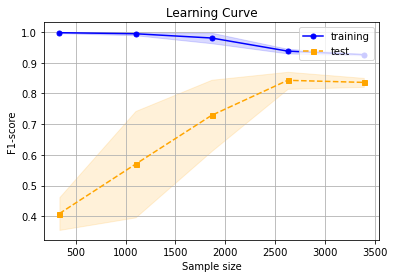

In [7]:
# Learning curve as function of sample size
pipe_forest = make_pipeline(RandomForestClassifier(random_state=RANDOM_STATE, 
                               class_weight='balanced_subsample',
                               n_estimators=150,
                               max_depth=20,
                               max_leaf_nodes=70,
                               max_features=40,
                               max_samples=0.9,
                               min_samples_leaf=2,
                               min_samples_split=10))

train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_forest,
                              X=X_over,
                              y=y_over,
                              train_sizes = np.linspace(0.1, 1.0, 5),
                              scoring=score_f1,   
                              cv=3)
train_mean= np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean= np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='training')
plt.fill_between(train_sizes, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='orange', linestyle='--', marker='s', markersize=5, label='test')
plt.fill_between(train_sizes, test_mean+test_std, test_mean-test_std, alpha=0.15, color='orange')
plt.grid()
plt.xlabel('Sample size')
plt.ylabel('F1-score')
plt.title('Learning Curve')
plt.legend(loc='upper right')
plt.show()

Validation curve:

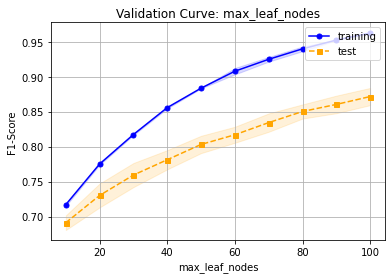

In [8]:
# Change on of the hyperparameters
pipe_forest = make_pipeline(RandomForestClassifier(random_state=RANDOM_STATE, 
                                                   class_weight='balanced_subsample',
                                                   n_estimators=150,
                                                   max_depth=20,
                                                   max_leaf_nodes=70,
                                                   max_features=40,
                                                   max_samples=0.9,
                                                   min_samples_leaf=2,
                                                   min_samples_split=10))
# Set parameter range
param_name = 'max_leaf_nodes'
param_range = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
train_scores, test_scores = \
                validation_curve(estimator=pipe_forest,
                              X=X_over,
                              y=y_over,
                              param_name='randomforestclassifier__'+param_name,
                              param_range =param_range,
                              scoring=score_f1,   
                              cv=3)
train_mean= np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean= np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='training')
plt.fill_between(param_range, train_mean+train_std, train_mean-train_std, alpha=0.15, color='blue')
plt.plot(param_range, test_mean, color='orange', linestyle='--', marker='s', markersize=5, label='test')
plt.fill_between(param_range, test_mean+test_std, test_mean-test_std, alpha=0.15, color='orange')
plt.grid()
plt.xlabel(param_name)
plt.ylabel('F1-Score')
plt.title('Validation Curve: ' + param_name)
plt.legend(loc='upper right')
plt.show()

Grid Search:

In [ ]:
gs = GridSearchCV(estimator = RandomForestClassifier(random_state=RANDOM_STATE, 
                               class_weight='balanced_subsample', n_estimators=100),
                  param_grid={'max_depth': [10, 20, 30],
                             'max_leaf_nodes': [30, 50, 70],
                             'max_features': [20, 40, 60],
                             'max_samples': [0.7, 0.9],
                             'min_samples_leaf':[2, 5, 7, 10],
                             'min_samples_split':[5, 10, 15]},
                  scoring = score_pr,
                  cv=2)

gs = gs.fit(X_over, y_over)
print(gs.best_params_)
#scores = cross_val_score(gs, X_over, y_over, scoring=score_pr, cv=2)
#print('CV precision: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

Random Forest Model:

In [9]:
forest = RandomForestClassifier(random_state=RANDOM_STATE, 
                               class_weight='balanced_subsample',
                               n_estimators=100,
                               max_depth=10,
                               max_leaf_nodes=90,
                               max_features=20,
                               max_samples=0.9,
                               min_samples_leaf=5,
                               min_samples_split=10)
# Train model
forest.fit(X_train, y_train)
# Prediction
y_true, y_pred = y_test, forest.predict(X_test)
# Classification report (recall, preccision, f-score, accuracy):
print(classification_report(y_true, y_pred))
print()
tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
print('TN:',tn, 'FP:',fp, 'FN:',fn, 'TP:',tp )
print()
scores = cross_val_score(forest, X_train, y_train, scoring=score_f1, cv=5)
print('CV F1-score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88      1089
           1       0.35      0.27      0.30       210

    accuracy                           0.80      1299
   macro avg       0.61      0.59      0.59      1299
weighted avg       0.78      0.80      0.79      1299


TN: 981 FP: 108 FN: 153 TP: 57

CV F1-score: 0.786 +/- 0.015


              precision    recall  f1-score   support

           0       0.90      0.81      0.85      1089
           1       0.35      0.52      0.42       210

    accuracy                           0.76      1299
   macro avg       0.62      0.67      0.63      1299
weighted avg       0.81      0.76      0.78      1299


TN: 884 FP: 205 FN: 101 TP: 109

CV F1-score: 0.783 +/- 0.009

No Skill: ROC AUC=0.500
Random Forest: ROC AUC=0.742


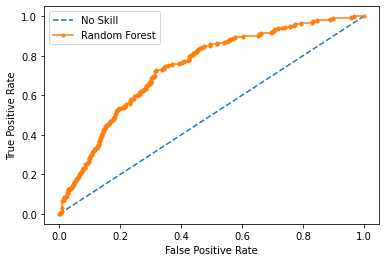


Random Forest: f1=0.416 auc=0.322


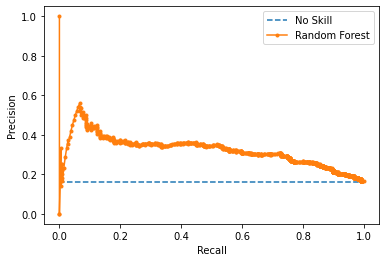

In [25]:
# Retrain Model for after sampled test set
forest = RandomForestClassifier(random_state=RANDOM_STATE, 
                               class_weight='balanced_subsample',
                               n_estimators=150,
                               max_depth=20,
                               max_leaf_nodes=70,
                               max_features=40,
                               max_samples=0.9,
                               min_samples_leaf=2,
                               min_samples_split=10)

# Train model
forest.fit(X_over, y_over)
# Prediction
y_true, y_pred = y_test, forest.predict(X_test)
# Classification report (recall, preccision, f-score, accuracy)
print(classification_report(y_true, y_pred))
print()
tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
print('TN:',tn, 'FP:',fp, 'FN:',fn, 'TP:',tp )
print()
scores = cross_val_score(forest, X_train, y_train, scoring=score_f1, cv=5)
print('CV F1-score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))
# ROC_AUC curve
print()
plt_roc_auc_curve(forest, X_test, y_test, model_name='Random Forest')
# Precision_Recall curve
print()
plt_precision_recall_curve(forest, X_test, y_test, model_name='Random Forest')  

In [11]:
# save classification report
clsf_report = pd.DataFrame(classification_report(y_true, y_pred, output_dict=True)).transpose()
clsf_report.to_csv('rand_forest_summary_report.csv', index= True)

#### Ensemble Learning:
- Logistic Regression
- Random Forest
- k-nearest Neighbors

In [86]:
clf1 = LogisticRegression(penalty='l2', C=0.0001, random_state=RANDOM_STATE, max_iter=8000)
clf2 = RandomForestClassifier(random_state=RANDOM_STATE, 
                               class_weight='balanced_subsample',
                               n_estimators=150,
                               max_depth=20,
                               max_leaf_nodes=70,
                               max_features=40,
                               max_samples=0.9,
                               min_samples_leaf=2,
                               min_samples_split=10)
clf3 = KNeighborsClassifier(n_neighbors=10, p=2, metric='minkowski')

clf_labels = ['Logistic Reg', 'Random Forest', 'KNN']
for clf, label in zip([clf1, clf2, clf3], clf_labels):
    scores = cross_val_score(estimator = clf,
                            X=X_over,
                            y=y_over,
                            cv=5,
                            scoring=score_f1)
    print('f-1 score:', scores.mean(), scores.std(), label)

f-1 score: 0.6516263615378044 0.014259096056788701 Logistic Reg
f-1 score: 0.8326789022191834 0.009025519397306928 Random Forest
f-1 score: 0.7110106730574878 0.010980145880698063 KNN


In [91]:
eclf = VotingClassifier(estimators=[
         ('lr', clf1), ('rf', clf2), ('knn', clf3)], voting='hard')
eclf = eclf.fit(X_over, y_over)
# Prediction
y_true, y_pred = y_test, eclf.predict(X_test)
# Classification report (recall, preccision, f-score, accuracy)
print(classification_report(y_true, y_pred))
print()
tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=y_pred).ravel()
print('TN:',tn, 'FP:',fp, 'FN:',fn, 'TP:',tp )
print()
scores = cross_val_score(forest, X_train, y_train, scoring=score_f1, cv=5)
print('CV F1-score: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1089
           1       0.32      0.55      0.41       210

    accuracy                           0.74      1299
   macro avg       0.61      0.66      0.62      1299
weighted avg       0.81      0.74      0.76      1299


TN: 843 FP: 246 FN: 94 TP: 116

CV F1-score: 0.783 +/- 0.009
